In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor



from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor




In [ ]:
#Step 2: Load Dataset
df = pd.read_csv("../data/new_dataset.csv")

In [3]:
# Filter by Type
# Create filtered subsets from df
house_df = df[df['type'].str.lower() == 'house'].copy()
apartment_df = df[df['type'].str.lower() == 'apartment'].copy()

In [ ]:
#drop columns
house_df.drop(columns=['apartment_postCode_avg_price_per_m2'], inplace=True, errors='ignore')
apartment_df.drop(columns=['house_postCode_avg_price_per_m2'], inplace=True, errors='ignore')

In [6]:
house_df.shape

(45228, 48)

In [7]:
apartment_df.shape

(31142, 48)

In [4]:
# Count apartments with hasLift == True
count_has_lift = apartment_df[apartment_df['hasLift'] == True].shape[0]

# Count apartments with non-null floorCount
count_has_floorCount = apartment_df['floorCount'].notna().sum()

# Print the results
print(f"Number of apartments with a lift: {count_has_lift}")
print(f"Number of apartments with floorCount info: {count_has_floorCount}")

Number of apartments with a lift: 18373
Number of apartments with floorCount info: 19084


In [5]:
# Step 3: Define mappings for ordinal features
state_map = {'AS_NEW': 0, 'JUST_RENOVATED': 1, 'GOOD': 2, 'TO_RENOVATE': 3, 'TO_RESTORE': 4, 'TO_BE_DONE_UP': 5}
epc_order = ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']

In [17]:
### Step 4: Define Features for Each Subset
# For house
house_features = ["province","bedroomCount", "bathroomCount", "facedeCount",
"habitableSurface", "gardenSurface", "epcScore", "house_postCode_avg_price_per_m2", 'buildingCondition']
 
### (['Unnamed: 0', 'id', 'url', 'type', 'subtype', 'bedroomCount',
    #    'bathroomCount', 'province', 'locality', 'postCode', 'habitableSurface',
    #    'roomCount', 'monthlyCost', 'hasAttic', 'hasBasement',
    #    'hasDressingRoom', 'diningRoomSurface', 'hasDiningRoom',
    #    'buildingCondition', 'buildingConstructionYear', 'facedeCount',
    #    'floorCount', 'streetFacadeWidth', 'hasLift', 'floodZoneType',
    #    'heatingType', 'hasHeatPump', 'hasPhotovoltaicPanels',
    #    'hasThermicPanels', 'kitchenSurface', 'kitchenType', 'landSurface',
    #    'hasLivingRoom', 'livingRoomSurface', 'hasBalcony', 'hasGarden',
    #    'gardenSurface', 'gardenOrientation', 'parkingCountIndoor', 
    #    'parkingCountOutdoor', 'hasAirConditioning', 'hasArmoredDoor',
    #    'hasVisiophone', 'hasOffice', 'toiletCount', 'hasSwimmingPool',
    #    'hasFireplace', 'hasTerrace', 'terraceSurface', 'terraceOrientation',
    #    'accessibleDisabledPeople', 'epcScore', 'price'],
# For apartment
    #    'floorCount', 'streetFacadeWidth', 'hasLift', 'floodZoneType',
apartment_features = ["province", "bedroomCount","bathroomCount", 'habitableSurface', "epcScore", 'hasLift',
'apartment_postCode_avg_price_per_m2', 'buildingCondition' ]

target = "price"

### First try with 
Preprocessing data: Uses OrdinalEncoder to Automatically fit and transform the data, determining order from the data


House Model Performance:
MAE: 128053.19126115787
RMSE: 307731.00984996016
R²: 0.7180063426288752


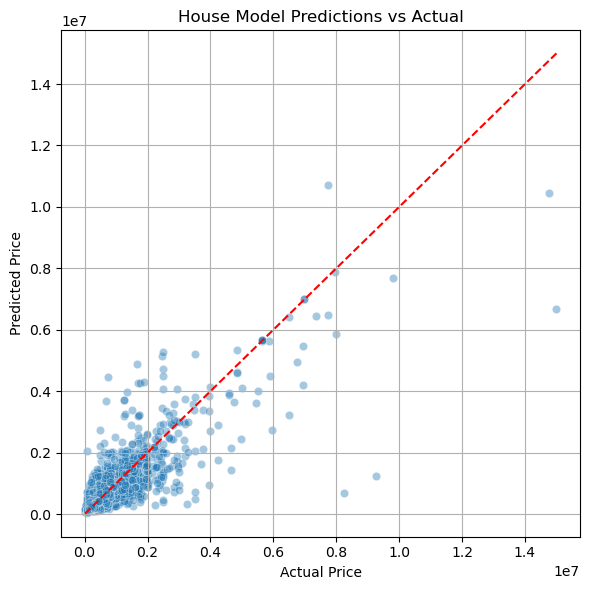


Apartment Model Performance:
MAE: 77264.51717701596
RMSE: 183752.0797241995
R²: 0.7821187545770767


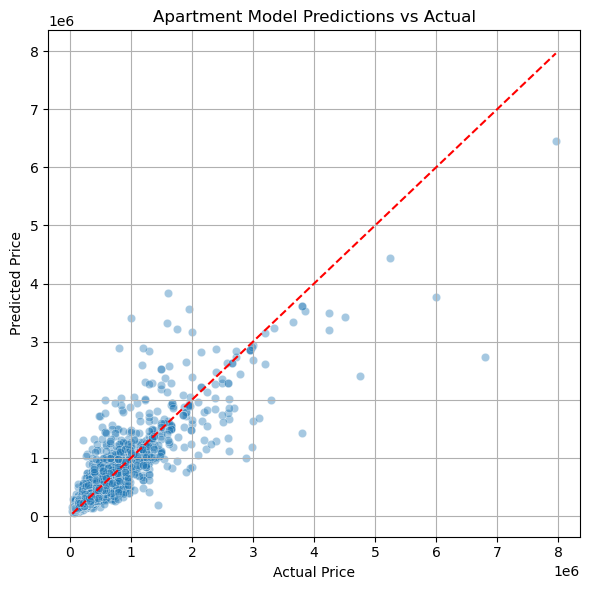

In [ ]:
# --- Step 4: Preprocessing function ---
def preprocess(df, features, target):
    df = df[features + [target]].copy()
    df = df.dropna(subset=[target])

    # --- Ordinal Encoding for EPC ---
    epc_order = ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
    epc_enc = OrdinalEncoder(categories=[epc_order], handle_unknown='use_encoded_value', unknown_value=-1)
    df['epcScore'] = epc_enc.fit_transform(df[['epcScore']])

    # --- Ordinal Encoding for buildingCondition ---
    cond_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df['buildingCondition'] = cond_enc.fit_transform(df[['buildingCondition']])

    # --- One-hot encoding for province/locality ---
    for col in ['province', 'locality']:
        if col in df.columns:
            df = pd.get_dummies(df, columns=[col], drop_first=True)

    # --- Boolean to integer if any ---
    if 'hasLift' in df.columns:
        df['hasLift'] = df['hasLift'].astype(float)

    # --- Impute missing numeric values ---
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    num_cols.remove(target)
    imputer = SimpleImputer(strategy='median')
    df[num_cols] = imputer.fit_transform(df[num_cols])

    X = df.drop(columns=[target])
    y = df[target]
    return X, y

# --- Step 5: Train + Evaluate ---
def train_and_evaluate(X, y, name="Model"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Performance:")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
    print("R²:", r2_score(y_test, y_pred))

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"{name} Predictions vs Actual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Step 5: Run for each type ---
X_house, y_house = preprocess(house_df, house_features, target)
train_and_evaluate(X_house, y_house, "House Model")

X_apartment, y_apartment = preprocess(apartment_df, apartment_features, target)
train_and_evaluate(X_apartment, y_apartment, "Apartment Model")

### RandomForestRegressor: 
House Model Performance:
- MAE: 128053.19126115787
- RMSE: 307731.00984996016
- R²: 0.7180063426288752

Apartment Model Performance:
- MAE: 77264.51717701596
- RMSE: 183752.0797241995
- R²: 0.7821187545770767


=== House Models ===
Linear Regression    | MAE: 216,582 | RMSE: 529,934 | R²: 0.164
Random Forest        | MAE: 127,106 | RMSE: 305,284 | R²: 0.722


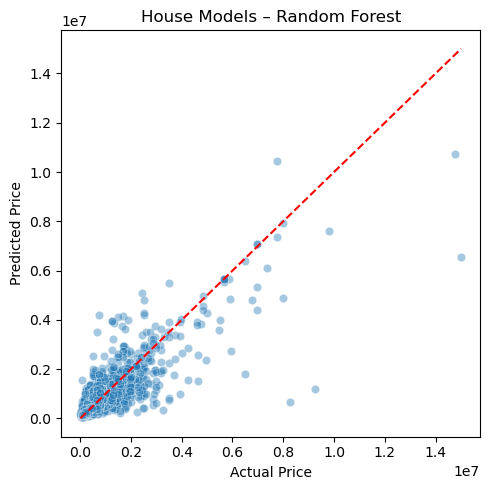

Gradient Boosting    | MAE: 144,866 | RMSE: 339,434 | R²: 0.657
XGBoost              | MAE: 130,759 | RMSE: 311,157 | R²: 0.712


c:\Users\Dieu\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network (MLP) | MAE: 197,577 | RMSE: 472,004 | R²: 0.337

=== Apartment Models ===
Linear Regression    | MAE: 76,965 | RMSE: 113,261 | R²: 0.532
Random Forest        | MAE: 51,742 | RMSE: 81,243 | R²: 0.759


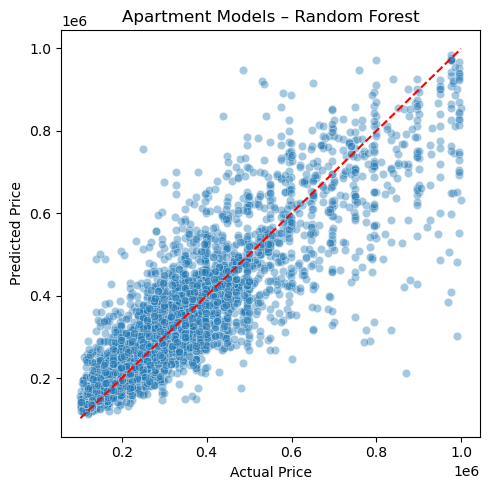

Gradient Boosting    | MAE: 55,819 | RMSE: 83,889 | R²: 0.743
XGBoost              | MAE: 52,659 | RMSE: 80,027 | R²: 0.767
Neural Network (MLP) | MAE: 66,306 | RMSE: 95,614 | R²: 0.667


c:\Users\Dieu\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
cond_map = {
    'AS_NEW':0, 'JUST_RENOVATED':1, 'GOOD':2,
    'TO_RENOVATE':3, 'TO_RESTORE':4, 'TO_BE_DONE_UP':5
}
for d in (house_df, apartment_df):
    d['buildingCondition'] = d['buildingCondition'].map(cond_map)

# --- 4. Preprocessing pipeline ---
#   - OneHotEncode province/locality/epcScore
#   - Median-impute all numeric features
def make_preprocessor(feature_list):
    # detect categorical vs numeric
    cat_cols = [c for c in feature_list if df[c].dtype=='object' or c=='epcScore']
    num_cols = [c for c in feature_list if c not in cat_cols]
    return ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', SimpleImputer(strategy='median'), num_cols)
    ])

# --- 5. Define models to compare ---
models = {
    'Linear Regression':        LinearRegression(),
    'Random Forest':            RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting':        GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost':                  XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'Neural Network (MLP)':     MLPRegressor(hidden_layer_sizes=(50,50), max_iter=300, random_state=42)
}

# --- 6. Train & evaluate for a given split ---
def run_models(df_subset, features, label):
    X = df_subset[features]
    y = df_subset[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    preprocessor = make_preprocessor(features)
    print(f"\n=== {label} ===")
    for name, model in models.items():
        pipe = Pipeline([
            ('prep', preprocessor),
            ('model', model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        mae  = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2   = r2_score(y_test, y_pred)

        print(f"{name:20s} | MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.3f}")

        # optional: plot only for one model
        if name=='Random Forest':
            plt.figure(figsize=(5,5))
            sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
            plt.plot([y_test.min(), y_test.max()],[y_test.min(),y_test.max()],'r--')
            plt.title(f"{label} – {name}")
            plt.xlabel("Actual Price")
            plt.ylabel("Predicted Price")
            plt.tight_layout()
            plt.show()

# --- 7. Execute ---
run_models(house_df,     house_features,     label="House Models")
run_models(apartment_df, apartment_features, label="Apartment Models")


=== House Models ===
Linear Regression    | MAE: 120,210 | RMSE: 174,920 | R²: 0.480
Random Forest        | MAE: 89,407 | RMSE: 136,079 | R²: 0.685


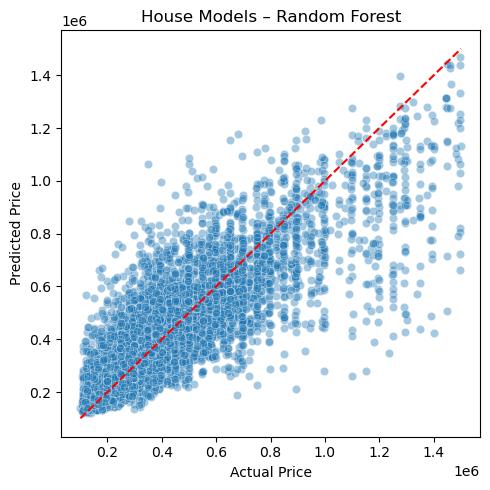

Gradient Boosting    | MAE: 98,451 | RMSE: 144,577 | R²: 0.645
XGBoost              | MAE: 89,599 | RMSE: 133,720 | R²: 0.696


c:\Users\Dieu\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network (MLP) | MAE: 109,601 | RMSE: 161,108 | R²: 0.559

=== Apartment Models ===
Linear Regression    | MAE: 89,119 | RMSE: 142,329 | R²: 0.567
Random Forest        | MAE: 73,692 | RMSE: 120,100 | R²: 0.692


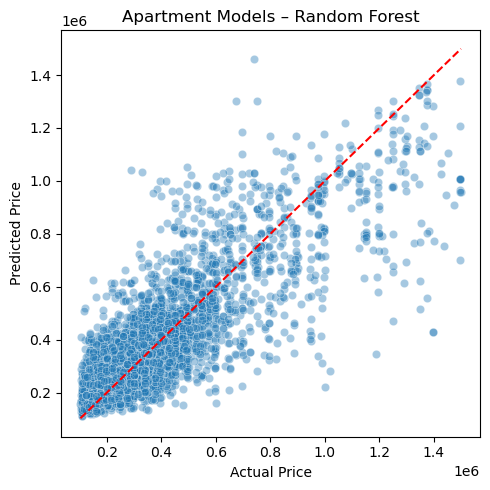

Gradient Boosting    | MAE: 77,293 | RMSE: 120,921 | R²: 0.688
XGBoost              | MAE: 73,959 | RMSE: 117,328 | R²: 0.706
Neural Network (MLP) | MAE: 89,754 | RMSE: 136,757 | R²: 0.600


c:\Users\Dieu\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# --- 1a. Remove extreme price outliers ---
# Keep only prices between €100k and €1.5M
house_df     = house_df[(house_df['price']  > 1e5) & (house_df['price']  < 1.5e6)]
apartment_df = apartment_df[(apartment_df['price']> 1e5) & (apartment_df['price']< 1e6)]

# --- 2. Feature definitions (without 'locality') ---
house_features = [
    'province','bedroomCount','bathroomCount',
    'facedeCount','terraceSurface','landSurface',
    'epcScore','buildingCondition', 'house_postCode_avg_price_per_m2'
]
apartment_features = [
    'province','bedroomCount','bathroomCount','floorCount',
    'hasLift','terraceSurface','epcScore','buildingCondition','apartment_postCode_avg_price_per_m2'
]
target = 'price'

# --- 3. Encode buildingCondition ordinally ---
cond_map = {
    'AS_NEW':0, 'JUST_RENOVATED':1, 'GOOD':2,
    'TO_RENOVATE':3, 'TO_RESTORE':4, 'TO_BE_DONE_UP':5
}
for d in (house_df, apartment_df):
    d['buildingCondition'] = d['buildingCondition'].map(cond_map)

# --- 4. Preprocessing builder (epcScore and province only) ---
def make_preprocessor(feature_list):
    cat_cols = [c for c in feature_list if c in ['province','epcScore']]
    num_cols = [c for c in feature_list if c not in cat_cols]
    return ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', SimpleImputer(strategy='median'), num_cols)
    ])

# --- 5. Models to compare ---
models = {
    'Linear Regression':        LinearRegression(),
    'Random Forest':            RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting':        GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost':                  XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'Neural Network (MLP)':     MLPRegressor(hidden_layer_sizes=(50,50), max_iter=300, random_state=42)
}

# --- 6. Train & evaluate for each subset ---
def run_models(df_subset, features, label):
    X = df_subset[features]
    y = df_subset[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    preprocessor = make_preprocessor(features)
    print(f"\n=== {label} ===")
    for name, model in models.items():
        pipe = Pipeline([
            ('prep', preprocessor),
            ('model', model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        mae  = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2   = r2_score(y_test, y_pred)

        print(f"{name:20s} | MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.3f}")

        # Optional: scatter plot for Random Forest
        if name=='Random Forest':
            plt.figure(figsize=(5,5))
            sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
            plt.plot([y_test.min(), y_test.max()],[y_test.min(),y_test.max()],'r--')
            plt.title(f"{label} – {name}")
            plt.xlabel("Actual Price")
            plt.ylabel("Predicted Price")
            plt.tight_layout()
            plt.show()

# --- 7. Execute ---
run_models(house_df,     house_features,     label="House Models")
run_models(apartment_df, apartment_features, label="Apartment Models")


 Since both XGBoost and Random Forest perform well in the current setup, tune XGBoost using GridSearchCV to improve the accuracy

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__subsample': 0.8}
MAE: 61,969 | RMSE: 94,125 | R²: 0.677


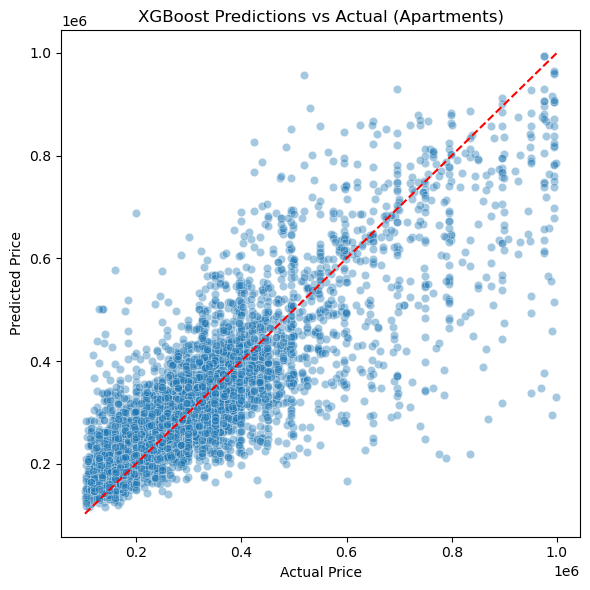

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


apartment_features = [
    'province', 'bedroomCount', 'bathroomCount', 'floorCount',
    'hasLift', 'terraceSurface', 'epcScore', 'buildingCondition',
    'apartment_postCode_avg_price_per_m2'
]
target = 'price'

# --- 2. Define Preprocessor ---
def make_preprocessor(feature_list):
    # Detect categorical and numerical columns
    cat_cols = [col for col in feature_list if apartment_df[col].dtype == 'object' or col == 'epcScore']
    num_cols = [col for col in feature_list if col not in cat_cols]
    
    return ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', SimpleImputer(strategy='median'), num_cols)
    ])

# --- 3. Filter and Split Data ---
apartment_df = apartment_df[(apartment_df['price'] > 1e5) & (apartment_df['price'] < 1e6)]

X = apartment_df[apartment_features]
y = apartment_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 4. Preprocessing Pipeline ---
preprocessor = make_preprocessor(apartment_features)

# --- 5. Pipeline + Model ---
xgb_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# --- 6. Grid Search Hyperparameters ---
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_depth': [3, 6, 10],
    'model__subsample': [0.8, 1.0]
}

grid = GridSearchCV(
    xgb_pipe,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

# --- 7. Fit and Evaluate ---
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)

y_pred = grid.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.3f}")

# --- 8. Optional: Visualization ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("XGBoost Predictions vs Actual (Apartments)")
plt.tight_layout()
plt.show()